# Test the Stereo Encoder

In [9]:
import os
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import torch

# import stereo network
from im2mesh.encoder.stereo import HdrnAlphaStereo, TruncatedHdrnStereoEncoder 
from im2mesh.encoder.conv import Resnet18
from typing import Optional, List


## Define utils to visualize dataset

In [2]:
def plot_image_lists(l_images, r_images):
    """
    Plot list of images side by side.

    Args:
        l_images (list): List of left images
        r_images (list): List of right images
    """
    im_dim = 2
    fig, axs = plt.subplots(len(l_images), 2, figsize=(2 * im_dim, len(l_images) * im_dim))
    for i in range(len(l_images)):
        axs[i, 0].imshow(l_images[i])
        axs[i, 1].imshow(r_images[i])
    plt.show()

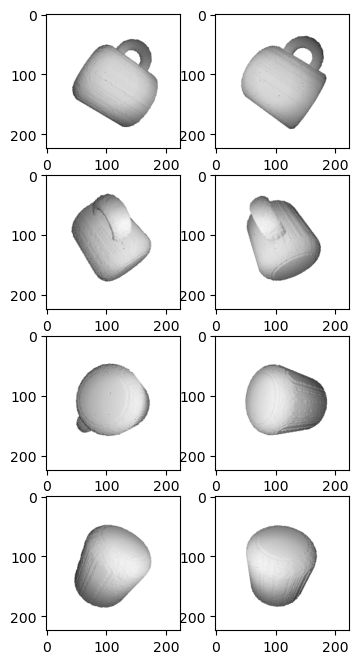

In [3]:
l_plot_image_list = []
r_plot_image_list = []
r_image_list = []
l_image_list = []

toy_data_path = '../../prototypes/'
for i in range(0, 4):
    test_data = np.load(osp.join(toy_data_path, '1a97f3c83016abca21d0de04f408950f', f'pose_{i}.npz'), allow_pickle=True)
    r_image_list.append(test_data['r_image'])
    l_image_list.append(test_data['l_image'])
    l_plot_image_list.append(np.einsum('ijk->jki', test_data['l_image']).astype(int))
    r_plot_image_list.append(np.einsum('ijk->jki', test_data['r_image']).astype(int))
    # print(test_data['pose'])
plot_image_lists(l_plot_image_list, r_plot_image_list)

## Test Original Model

In [4]:
class ModelConfig(object):
    model_file: str = None
    model_name: str = None 

    fe_features: int = 16
    fe_internal_features: int = 32
    num_disparities: int = 128
    downsample_factor: int = 4  # Was 8

    checkpoint: Optional[str] = None

hparams = ModelConfig()
model = HdrnAlphaStereo(hparams)

In [5]:
# Note: data shape should be (batch_size, 3, height, width)
l_image_batch = np.stack(l_image_list, axis=0)
r_image_batch = np.stack(r_image_list, axis=0)
l_image_batch_torch = torch.from_numpy(l_image_batch)
r_image_batch_torch = torch.from_numpy(r_image_batch)
print(l_image_batch.shape)
output, all_outputs = model.forward(l_image_batch_torch, r_image_batch_torch)


(4, 3, 224, 224)
Cost volume ori:  torch.Size([4, 16, 32, 56, 56])
Cost volume:  torch.Size([4, 32, 56, 56])
idx tensor:  [1, 32, 1, 1]
Disparity small:  torch.Size([4, 1, 56, 56])
Matchability:  torch.Size([4, 1, 56, 56])
Disparity:  torch.Size([4, 1, 224, 224])


torch.Size([4, 1, 224, 224])


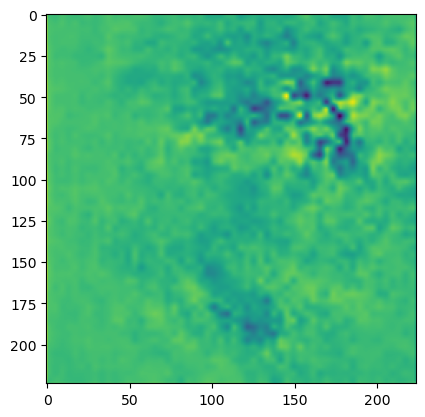

In [6]:
disparity = output['disparity']
print(disparity.shape)
plt.imshow(torch.einsum('ijk->jki', disparity[0]).detach().numpy())

# Test Truncated Model

In [7]:
class ModelConfig(object):
    model_file: str = None
    model_name: str = None 

    fe_features: int = 16
    fe_internal_features: int = 32
    num_disparities: int = 128
    downsample_factor: int = 4

    checkpoint: Optional[str] = None

hparams = ModelConfig()
model = TruncatedHdrnStereoEncoder(hparams, c_dim=512)

# Note: data shape should be (batch_size, 3, height, width)
l_image_batch = np.stack(l_image_list, axis=0)
r_image_batch = np.stack(r_image_list, axis=0)
l_image_batch_torch = torch.from_numpy(l_image_batch)
r_image_batch_torch = torch.from_numpy(r_image_batch)
# print(l_image_batch.shape)
embedding = model.forward(l_image_batch_torch, r_image_batch_torch)

Cost volume ori:  torch.Size([4, 16, 32, 56, 56])


In [8]:
print(embedding.shape)

torch.Size([4, 512])


# Reference Conv Model

In [10]:
resnet = Resnet18(c_dim=512)
ref_embedding = resnet.forward(l_image_batch_torch)
print(ref_embedding.shape)


/home/elchun/miniconda3/envs/stereo-occ/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/elchun/miniconda3/envs/stereo-occ/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([4, 512])
